# Домашнее задание к уроку 2: Линейная и логистическая регрессия

## Цель задания
Закрепить навыки работы с PyTorch API, изучить модификацию моделей и работу с различными датасетами.

## Задание 1: Модификация существующих моделей (30 баллов)

Создайте файл `homework_model_modification.py`:

### 1.1 Расширение линейной регрессии (15 баллов)
```python
# Модифицируйте существующую линейную регрессию:
# - Добавьте L1 и L2 регуляризацию
# - Добавьте early stopping
```

Тренировочный датасет: 160
Валидационный датасет: 40
Early stopping для эпохи 10
Обучение завершено с лучшей validation loss: 0.2011


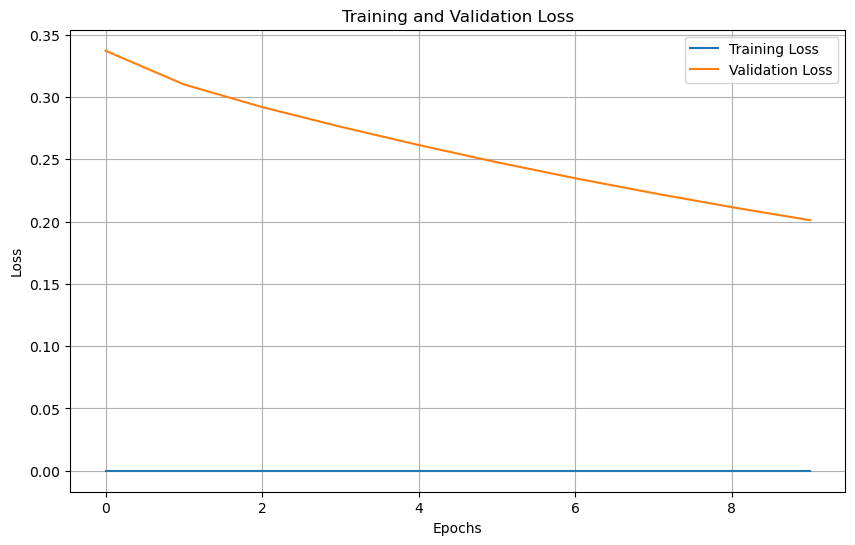

In [3]:
import torch
from torch.utils.data import DataLoader
from utils import make_regression_data, mse, log_epoch, RegressionDataset
import matplotlib.pyplot as plt

class LinearRegressionManual:
    def __init__(self, in_features, l1_lambda=0.01, l2_lambda=0.01):
        self.w = torch.randn(in_features, 1, dtype=torch.float32, requires_grad=False)
        self.b = torch.zeros(1, dtype=torch.float32, requires_grad=False)
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.best_loss = float('inf')
        self.best_weights = None

    def __call__(self, X):
        return X @ self.w + self.b

    def parameters(self):
        return [self.w, self.b]

    def zero_grad(self):
        self.dw = torch.zeros_like(self.w)
        self.db = torch.zeros_like(self.b)

    def backward(self, X, y, y_pred):
        n = X.shape[0]
        error = y_pred - y
        self.dw = (X.T @ error) / n
        self.db = error.mean(0)
        # Добавляем регуляризацию
        if self.l1_lambda > 0:
            self.dw += self.l1_lambda * torch.sign(self.w)
        if self.l2_lambda > 0:
            self.dw += self.l2_lambda * 2 * self.w

    def step(self, lr):
        self.w -= lr * self.dw
        self.b -= lr * self.db

    def save(self, path):
        torch.save({'w': self.w, 'b': self.b}, path)

    def load(self, path):
        state = torch.load(path)
        self.w = state['w']
        self.b = state['b']  
        
    def save_best_weights(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_weights = (self.w.clone(), self.b.clone())
            
    def restore_best_weights(self):
        if self.best_weights is not None:
            self.w, self.b = self.best_weights

if __name__ == '__main__':
    # Генерируем данные
    X, y = make_regression_data(n=200)
    
    split_idx = int(0.8 * len(X))
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_val, y_val = X[split_idx:], y[split_idx:]

    # Создаём датасет и даталоадер
    train_dataset = RegressionDataset(X_train, y_train)
    val_dataset = RegressionDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    print(f'Тренировочный датасет: {len(train_dataset)}')
    print(f'Валидационный датасет: {len(val_dataset)}')

    
    # Обучаем модель
    model = LinearRegressionManual(in_features=1)
    lr = 0.1
    epochs = 100
    patience = 10  # Количество эпох без улучшения для early stopping
    no_improve = 0  # Счетчик эпох без улучшения
    train_losses = []
    val_losses = []
    
    for epoch in range(1, epochs + 1):
        total_train_loss = 0
        
        for i, (batch_X, batch_y) in enumerate(train_loader):
            y_pred = model(batch_X)
            loss = mse(y_pred, batch_y)
            total_loss += loss
            
            model.zero_grad()
            model.backward(batch_X, batch_y, y_pred)
            model.step(lr)
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        total_val_loss = 0
        with torch.no_grad():
            for i, (batch_X, batch_y) in enumerate(val_loader):
                y_pred = model(batch_X)
                loss = mse(y_pred, batch_y)
                total_val_loss += loss
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        model.save_best_weights(avg_val_loss)
        if avg_val_loss < model.best_loss:
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping для эпохи {epoch}")
                model.restore_best_weights()
                break
                
                
        avg_loss = total_loss / (i + 1)
        if epoch % 10 == 0:
            log_epoch(epoch, avg_loss)
        
    
    print("Обучение завершено с лучшей validation loss: {:.4f}".format(model.best_loss))
    
    model.save('linreg_manual.pth') 

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curve.png')
    plt.show()

### 1.2 Расширение логистической регрессии (15 баллов)
```python
# Модифицируйте существующую логистическую регрессию:
# - Добавьте поддержку многоклассовой классификации
# - Реализуйте метрики: precision, recall, F1-score, ROC-AUC
# - Добавьте визуализацию confusion matrix
```

Epoch 10: loss=0.3981
Epoch 20: loss=0.2788
Epoch 30: loss=0.2379
Epoch 40: loss=0.2172
Epoch 50: loss=0.2045
Epoch 60: loss=0.1959
Epoch 70: loss=0.1899
Epoch 80: loss=0.1856
Epoch 90: loss=0.1823
Epoch 100: loss=0.1798

Classification Metrics:
Precision: 0.9333
Recall: 0.9360
F1 Score: 0.9332
ROC-AUC: 0.9853


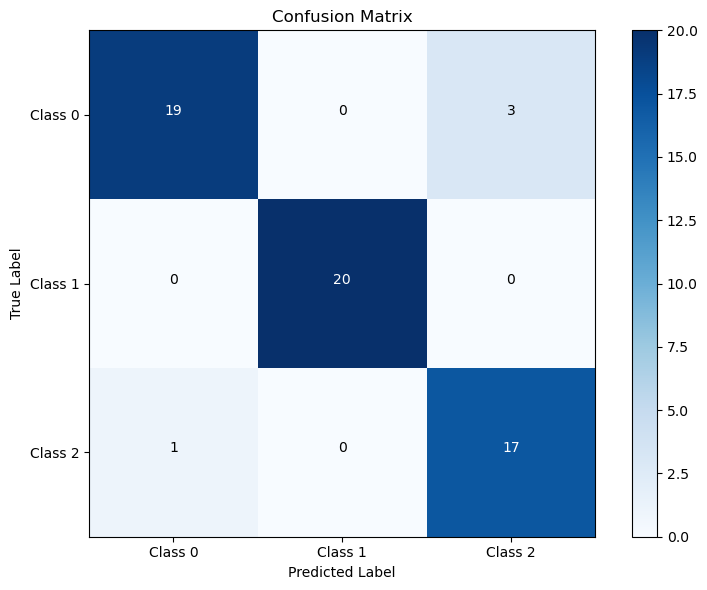

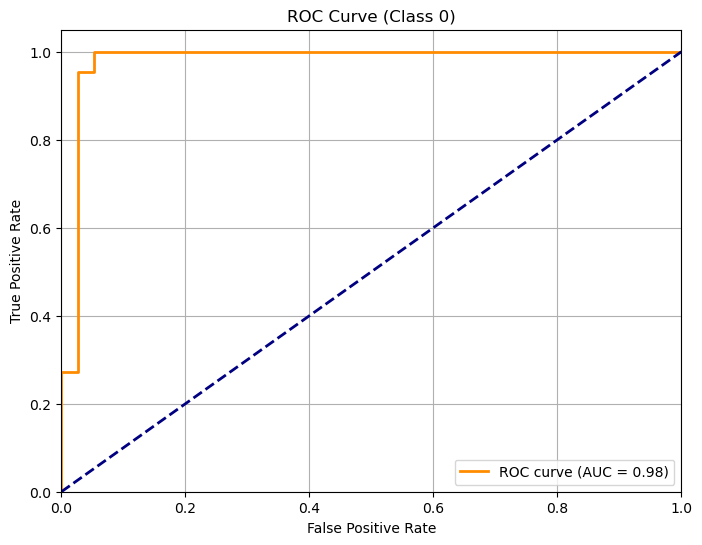

Model saved to 'multiclass_logreg.pth'


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from utils import ClassificationDataset, make_classification_data, log_epoch

class MulticlassLogisticRegression(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.linear = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.linear(x)
    
    def predict_proba(self, x):
        logits = self.forward(x)
        return torch.softmax(logits, dim=1)
    
    def predict(self, x):
        proba = self.predict_proba(x)
        return torch.argmax(proba, dim=1)

def calculate_metrics(y_true, y_pred, y_proba, num_classes):
    metrics = {}
    confusion = np.zeros((num_classes, num_classes), dtype=int)
    
    # Вычисляем confusion matrix
    for true, pred in zip(y_true, y_pred):
        confusion[true, pred] += 1
    
    precisions = []
    recalls = []
    f1_scores = []
    
    for i in range(num_classes):
        tp = confusion[i, i]
        fp = np.sum(confusion[:, i]) - tp
        fn = np.sum(confusion[i, :]) - tp
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
    metrics['precision'] = np.mean(precisions)
    metrics['recall'] = np.mean(recalls)
    metrics['f1'] = np.mean(f1_scores)
    
    if num_classes == 2:
        fpr, tpr, roc_auc = calculate_binary_roc(y_true, y_proba[:, 1])
        metrics['roc_auc'] = roc_auc
    else:
        auc_scores = []
        for i in range(num_classes):
            bin_y_true = (y_true == i).astype(int)
            bin_y_proba = y_proba[:, i]
            fpr, tpr, roc_auc = calculate_binary_roc(bin_y_true, bin_y_proba)
            auc_scores.append(roc_auc)
        metrics['roc_auc'] = np.mean(auc_scores)
    
    metrics['confusion_matrix'] = confusion
    return metrics

def calculate_binary_roc(y_true, y_proba):
    indices = np.argsort(y_proba)[::-1]
    y_true_sorted = y_true[indices]
    y_proba_sorted = y_proba[indices]
    
    
    fpr_list = []
    tpr_list = []
    auc = 0.0
    
    total_pos = np.sum(y_true_sorted)
    total_neg = len(y_true_sorted) - total_pos
    
    fpr_list.append(0.0)
    tpr_list.append(0.0)
    
    fp = 0
    tp = 0
    prev_fpr = 0.0
    prev_tpr = 0.0
    prev_proba = None
    
    for i in range(len(y_proba_sorted)):
        current_proba = y_proba_sorted[i]
        
        if current_proba == prev_proba:
            if y_true_sorted[i] == 1:
                tp += 1
            else:
                fp += 1
            continue
        
        current_fpr = fp / total_neg if total_neg > 0 else 0.0
        current_tpr = tp / total_pos if total_pos > 0 else 0.0
        
        fpr_list.append(current_fpr)
        tpr_list.append(current_tpr)
        
        dx = current_fpr - prev_fpr
        y_avg = (current_tpr + prev_tpr) / 2.0
        auc += dx * y_avg
        
        prev_fpr = current_fpr
        prev_tpr = current_tpr
        prev_proba = current_proba
        
        if y_true_sorted[i] == 1:
            tp += 1
        else:
            fp += 1
    
    if total_neg > 0:
        current_fpr = fp / total_neg
    else:
        current_fpr = 0.0
        
    if total_pos > 0:
        current_tpr = tp / total_pos
    else:
        current_tpr = 0.0
        
    fpr_list.append(current_fpr)
    tpr_list.append(current_tpr)
    
    # Обновляем AUC для последнего сегмента
    dx = current_fpr - prev_fpr
    y_avg = (current_tpr + prev_tpr) / 2.0
    auc += dx * y_avg
    
    return np.array(fpr_list), np.array(tpr_list), auc

def plot_confusion_matrix(confusion, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(confusion[i, j]),
                     horizontalalignment="center",
                     color="white" if confusion[i, j] > confusion.max()/2 else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

def plot_roc_curve(fpr, tpr, roc_auc, title='ROC Curve'):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('roc_curve.png')
    plt.show()

if __name__ == '__main__':
    torch.manual_seed(42)
    n_classes = 3
    n_features = 4
    n_samples = 300
    
    centers = torch.randn(n_classes, n_features) * 2.0
    
    X = torch.zeros(n_samples, n_features)
    y = torch.zeros(n_samples, dtype=torch.long)
    
    for i in range(n_samples):
        class_idx = torch.randint(0, n_classes, (1,)).item()
        X[i] = centers[class_idx] + torch.randn(n_features) * 0.5
        y[i] = class_idx
    
    split_idx = int(0.8 * n_samples)
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_test, y_test = X[split_idx:], y[split_idx:]
    
    train_dataset = ClassificationDataset(X_train, y_train)
    test_dataset = ClassificationDataset(X_test, y_test)
    
    model = MulticlassLogisticRegression(in_features=n_features, num_classes=n_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    
    epochs = 100
    train_losses = []
    
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        
        optimizer.zero_grad()
        logits = model(X_train)
        loss = criterion(logits, y_train)
        loss.backward()
        optimizer.step()
        
        total_loss = loss.item()
        train_losses.append(total_loss)
        
        if epoch % 10 == 0:
            log_epoch(epoch, total_loss)
    
    model.eval()
    with torch.no_grad():
        test_logits = model(X_test)
        test_proba = torch.softmax(test_logits, dim=1)
        test_pred = torch.argmax(test_proba, dim=1)
        
        y_true_np = y_test.numpy()
        y_pred_np = test_pred.numpy()
        y_proba_np = test_proba.numpy()
        
        metrics = calculate_metrics(y_true_np, y_pred_np, y_proba_np, n_classes)
        
        print("\nClassification Metrics:")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1']:.4f}")
        print(f"ROC-AUC: {metrics['roc_auc']:.4f}")
        
        class_names = [f'Class {i}' for i in range(n_classes)]
        plot_confusion_matrix(metrics['confusion_matrix'], classes=class_names)
        
        if n_classes == 2:
            fpr, tpr, _ = calculate_binary_roc(y_true_np, y_proba_np[:, 1])
            plot_roc_curve(fpr, tpr, metrics['roc_auc'], title='ROC Curve (Class 1)')
        else:
        
            bin_y_true = (y_true_np == 0).astype(int)
            bin_y_proba = y_proba_np[:, 0]
            fpr, tpr, roc_auc = calculate_binary_roc(bin_y_true, bin_y_proba)
            plot_roc_curve(fpr, tpr, roc_auc, title='ROC Curve (Class 0)')
    
    torch.save(model.state_dict(), 'multiclass_logreg.pth')
    print("Model saved to 'multiclass_logreg.pth'")

## Задание 2: Работа с датасетами (30 баллов)

Создайте файл `homework_datasets.py`:

### 2.1 Кастомный Dataset класс (15 баллов)
```python
# Создайте кастомный класс датасета для работы с CSV файлами:
# - Загрузка данных из файла
# - Предобработка (нормализация, кодирование категорий)
# - Поддержка различных форматов данных (категориальные, числовые, бинарные и т.д.)
```

In [3]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CSVDataset(Dataset):
    def __init__(self, file_path, target_column=None, numerical_columns=None,
                 categorical_columns=None, binary_columns=None, normalize_numeric=True,
                 onehot_encode_categories=True, header='infer', column_names=None):
        # Загрузка данных
        self.data = pd.read_csv(file_path, header=header, names=column_names)
        self.target_column = target_column
        self.numerical_columns = numerical_columns or []
        self.categorical_columns = categorical_columns or []
        self.binary_columns = binary_columns or []
        self.normalization_params = {}
        self.category_mappings = {}
        self.binary_mappings = {}
        
        # Автоматическое определение типов колонок
        if not any([numerical_columns, categorical_columns, binary_columns]):
            self._auto_detect_column_types()
            
        # Предобработка данных
        self._preprocess_data(normalize_numeric, onehot_encode_categories)

    def _auto_detect_column_types(self):
        for col in self.data.columns:
            if col == self.target_column:
                continue
            if pd.api.types.is_numeric_dtype(self.data[col]):
                unique_vals = self.data[col].nunique()
                if unique_vals == 2:
                    self.binary_columns.append(col)
                else:
                    self.numerical_columns.append(col)
            else:
                self.categorical_columns.append(col)

    def _preprocess_data(self, normalize_numeric, onehot_encode_categories):
        # Обработка бинарных колонок
        for col in self.binary_columns:
            unique_vals = self.data[col].unique()
            self.binary_mappings[col] = {val: i for i, val in enumerate(unique_vals)}
            self.data[col] = self.data[col].map(self.binary_mappings[col])
        
        # Обработка категориальных колонок
        for col in self.categorical_columns:
            unique_vals = self.data[col].unique()
            self.category_mappings[col] = {val: i for i, val in enumerate(unique_vals)}
            if onehot_encode_categories:
                onehot = pd.get_dummies(self.data[col], prefix=col)
                self.data = pd.concat([self.data.drop(col, axis=1), onehot], axis=1)
                self.categorical_columns.remove(col)
                self.categorical_columns.extend(onehot.columns)
            else:
                self.data[col] = self.data[col].map(self.category_mappings[col])
        
        # Обработка числовых колонок
        for col in self.numerical_columns:
            if normalize_numeric:
                mean = self.data[col].mean()
                std = self.data[col].std()
                self.normalization_params[col] = {'mean': mean, 'std': std}
                self.data[col] = (self.data[col] - mean) / std
        
        # Разделение на признаки и целевую переменную
        if self.target_column:
            self.targets = self.data[self.target_column].values
            self.features = self.data.drop(self.target_column, axis=1).values
        else:
            self.targets = None
            self.features = self.data.values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = self.features[idx].astype(np.float32)
        if self.target_column:
            target = self.targets[idx]
            if isinstance(target, (int, float)):
                target = np.array([target], dtype=np.float32)
            return features, target
        return features

    def get_feature_names(self):
        return list(self.data.drop(self.target_column, axis=1).columns) if self.target_column else list(self.data.columns)

# Пример использования
if __name__ == "__main__":
    # Создаем тестовый CSV файл
    data = {
        'age': [25, 30, 35, 40, 45],
        'income': [50000, 60000, 70000, 80000, 90000],
        'gender': ['M', 'F', 'M', 'F', 'M'],
        'employed': ['yes', 'no', 'yes', 'yes', 'no'],
        'target': [0, 1, 0, 1, 0]
    }
    df = pd.DataFrame(data)
    df.to_csv('test_data.csv', index=False)
    
    # Загружаем данные
    dataset = CSVDataset(
        file_path='test_data.csv',
        target_column='target',
        normalize_numeric=True,
        onehot_encode_categories=True
    )

    print('read')


KeyboardInterrupt



### 2.2 Эксперименты с различными датасетами (15 баллов)
```python
# Найдите csv датасеты для регрессии и бинарной классификации и, применяя наработки из предыдущей части задания, обучите линейную и логистическую регрессию
```

In [ ]:
# Загрузка и подготовка данных
regression_dataset = CSVDataset(
    file_path='insurance.csv',
    target_column='charges',
    categorical_columns=['sex', 'smoker', 'region'],
    normalize_numeric=True
)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    regression_dataset.features,
    regression_dataset.targets,
    test_size=0.2,
    random_state=42
)

# Конвертация в тензоры PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Создание модели
class LinearRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return self.linear(x)

# Обучение модели
model = LinearRegression(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# Оценка модели
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor)
    test_loss = criterion(test_preds, y_test_tensor)
    r2 = 1 - test_loss / torch.var(y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}, R²: {r2.item():.4f}')

## Задание 3: Эксперименты и анализ (20 баллов)

Создайте файл `homework_experiments.py`:

### 3.1 Исследование гиперпараметров (10 баллов)
```python
# Проведите эксперименты с различными:
# - Скоростями обучения (learning rate)
# - Размерами батчей
# - Оптимизаторами (SGD, Adam, RMSprop)
# Визуализируйте результаты в виде графиков или таблиц
```

### 3.2 Feature Engineering (10 баллов)
```python
# Создайте новые признаки для улучшения модели:
# - Полиномиальные признаки
# - Взаимодействия между признаками
# - Статистические признаки (среднее, дисперсия)
# Сравните качество с базовой моделью
```